# Evaluating model performance with different train / test groups

In [1]:
#standard 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

#model to use
from sklearn.ensemble import RandomForestClassifier

#model performance
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time

#for easy visualization of model performance
import scikitplot as skplt

#custom function for trim mean and std deviation
def trim_mean_std(data, frac=0.05):    
    mean = stats.trim_mean(data, frac)
    std = stats.tstd(data, limits=(frac * np.max(data), (1 - frac) * np.max(data)))
    return mean, std

#Dictionary to convert amino acid abreviations
aa_dict = {'ALA': 'A', 'CYS':'C', 'ASP': 'D', 'GLU':'E',
          'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
          'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
          'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T',
          'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

#Dictionary to bucket amino acids
condensed_dict = {'L': 'LAIVMH', 'A': 'LAIVMH', 'I': 'LAIVMH', 'V': 'LAIVMH', 'M': 'LAIVMH', 'H': 'LAIVMH',
                  'D': 'DEQ', 'E': 'DEQ', 'Q': 'DEQ', 
                  'S': 'STGRFN', 'T': 'STGRFN', 'G': 'STGRFN', 'R': 'STGRFN', 'F': 'STGRFN', 'N': 'STGRFN',
                  'K': 'K'}

In [41]:
def create_filter(AA_excluded, y, reverse=False):
    all_labels = ['L','A', 'I', 'V', 'D', 'E', 'Q', 'S', 'T', 'F', 'G', 'H', 'R', 'K', 'C', 'N', 'M', 'W', 'Y' ]
    labels = [x for x in all_labels if x not in AA_excluded]
    my_filter = [True if aa not in AA_excluded else False for aa in y]
    if reverse == True:
        reverse_filter = [True if aa in AA_excluded else False for aa in y]
        return my_filter, labels, reverse_filter
    else:
        return my_filter, labels
#normal z score function
def z_score(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    zeroed_data = np.subtract(data, means)
    scaled_data = np.divide(zeroed_data, stds)
    return scaled_data 

#trim z score function
def trim_log_z_score(data, frac=0.05):
    '''
    Args:
    data (NUMPY ARRAY!!): numpy array of data to be log transformed and scaled, not robust to negative numbers
    frac (float): how much to trim mean and standard deviation
    Returns:
    scaled_data (numpy array): log transformed and scaled data
    '''
    log_data = np.log(np.clip(data, 0.1, None))
    trim_means_and_std = np.apply_along_axis(func1d=trim_mean_std, axis=0, arr=log_data, frac=frac)
    means = trim_means_and_std[0,:].reshape(1,-1)
    stds = trim_means_and_std[1,:].reshape(1,-1)
    zeroed_data = np.subtract(log_data, means)
    scaled_data = np.divide(zeroed_data, stds)
    return scaled_data

def create_ratios(data):
    ratio_cols = ['1/0', '5/0', '10/0', '5/1', '10/1', '10/5']
    div_by_zero = data[['1%', '5%', '10%']].values / data[['0%']].values 
    div_by_one = data[['5%', '10%']].values / data[['1%']].values
    div_by_five = data[['10%']].values / data[['5%']].values
    ratios = np.concatenate((div_by_zero, div_by_one, div_by_five), axis=1)
    ratios_df = pd.DataFrame(ratios, columns=ratio_cols)
    return ratios_df

def ft_eng_and_scale(data):
    nums = ['0%', '1%', '5%', '10%']
    ratio_cols = ['1/0', '5/0', '10/0', '5/1', '10/1', '10/5']
    ratios_df = create_ratios(data)
    log_z_signal = trim_log_z_score(data[nums].values)
    z_ratio = z_score(ratios_df.values)
    X = np.concatenate((log_z_signal, z_ratio), axis=1)
    X_df = pd.DataFrame(X, columns=(nums+ratio_cols))
    X_df['AA'] = data['AA']
    return X_df

In [97]:
#importing data
IGPS = pd.read_csv('data/IGPS_labeled.csv').dropna(axis=0)
PTP1B = pd.read_csv('data/PTP1B_labeled.csv').dropna(axis=0)

#preprocessing data
IGPS_processed = ft_eng_and_scale(IGPS)
PTP1B_processed = ft_eng_and_scale(PTP1B)

#combining data
both_proteins = pd.concat([IGPS_processed, PTP1B_processed] , axis=0, ignore_index=True)

#label protein in overall array
proteins = ['IGPS'] * IGPS_processed.shape[0] + ['PTP1B'] * (both_proteins.shape[0] - IGPS_processed.shape[0])
both_proteins['protein'] = pd.Series(proteins, dtype='category')
both_proteins.AA = both_proteins.AA.astype('category')

#Check imported data
both_proteins.head()

,0%,1%,5%,10%,1/0,5/0,10/0,5/1,10/1,10/5,AA,protein
0,-0.387254,-0.424029,-0.116963,-0.998261,-0.073245,0.163008,-0.961024,0.249033,-0.996243,-1.417733,A,IGPS
1,-0.955255,-0.877532,-0.189045,-0.904572,0.443453,0.872418,-0.570100,0.793035,-0.670377,-1.250451,A,IGPS
2,0.049362,0.568272,0.567189,-0.073820,1.790568,0.948550,-0.372455,0.288477,-0.700201,-1.062712,A,IGPS
3,-1.961281,-1.954593,-1.145581,-1.211031,0.450525,0.370053,-0.202033,0.246927,-0.297379,-0.531936,A,IGPS
4,0.153584,0.472364,0.403590,0.491781,1.008014,0.423224,0.276278,0.074660,0.048036,0.039257,C,IGPS


In [98]:
AA_excluded_PTP1B = ['W', 'Y', 'C'] 

my_filter, labels, my_rev_filter = create_filter(AA_excluded_PTP1B, both_proteins.AA, reverse=True)

In [99]:
filtered_df = both_proteins.iloc[my_filter, :]

In [109]:
splits = ['by_protein', 'test_20', 'test_10']
by_protein = [filtered_df[filtered_df.protein=='PTP1B'].iloc[:,:10],
             filtered_df[filtered_df.protein=='IGPS'].iloc[:,:10],
             filtered_df[filtered_df.protein=='PTP1B'].AA,
             filtered_df[filtered_df.protein=='IGPS'].AA]
test_20 = train_test_split(
    filtered_df.iloc[:,:10], filtered_df.AA, test_size=0.2, random_state=0)
test_10 = train_test_split(
    filtered_df.iloc[:,:10], filtered_df.AA, test_size=0.1, random_state=0)
split_arrays = dict(zip(splits, [by_protein, test_20, test_10]))

In [110]:
params = {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 7}

In [116]:
def model_fit_and_pred(X_train, X_test, y_train, y_test, data_split):
    #define model, fit, and predict
    clf = RandomForestClassifier(n_estimators=100, **params, random_state=0)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    
    #condense predictions to buckets of interest
    y_condensed = np.array([condensed_dict[i] for i in y_test])
    preds_condensed = np.array([condensed_dict[i] for i in y_preds])
    
    #plot whole confusion matrix
    #ax = skplt.metrics.plot_confusion_matrix(y_test, y_preds, normalize=False,
    #                                figsize=(12,12), title_fontsize='large', text_fontsize='large')
    #ax.set_ylim(14.5, -0.5)
    
    #plot confusion matrix
    ax = skplt.metrics.plot_confusion_matrix(y_condensed, preds_condensed, normalize=False, labels = ['LAIVMH', 'DEQ', 'STGRFN', 'K'], 
                                    figsize=(8,8), title_fontsize='large', text_fontsize='large')
    ax.set_ylim(3.5, -0.5)
    ax.set_title(data_split)
    
    #get precision and recall for each bucket, accuracy for whole thing
    val_confusion_cond = confusion_matrix(y_condensed, preds_condensed)
    accuracy_cond = np.trace(val_confusion_cond) / np.sum(val_confusion_cond)
    
    return accuracy_cond

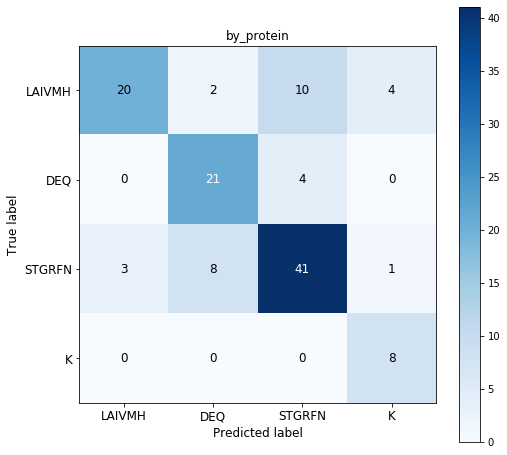

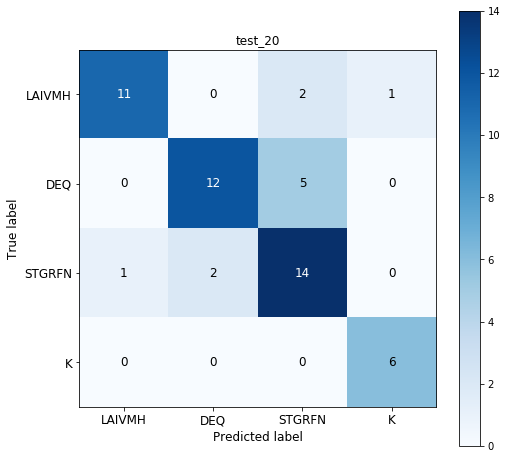

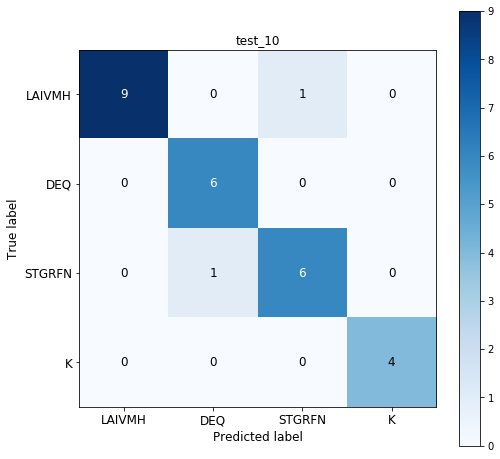

In [118]:
accuracies = []
for split, array_l in split_arrays.items():
    accuracies.append(model_fit_and_pred(*array_l, split))

In [125]:
for i in range(3):
    print(f'Model fit with {list(split_arrays.keys())[i]} has accuracy of {accuracies[i]}')

Model fit with by_protein has accuracy of 0.7377049180327869
Model fit with test_20 has accuracy of 0.7962962962962963
Model fit with test_10 has accuracy of 0.9259259259259259
